# Identifying Bias and Correlations Guide


## What you'll do

You will learn to identify bias and correlations, understand their impact on your data, and mitigate them in the future.


## What you'll learn

- You'll learn how to use DataEval's `balance`, `diversity` and `parity` functions to identify bias and correlations present in a dataset.
- You'll be able to create a workflow using DataEval for identifying bias.


## What you'll need

- Environment Requirements
  - `torchvision`
  - `matplotlib`

---


## Introduction

Identifying any biases or correlations present in a dataset is essential to accurately interpreting your model's performance and its ability to generalize to new data.
A common cause of poor generalization is shortcut learning &mdash; where a model uses secondary or background information to make predictions &mdash; which is enabled or exacerbated by dataset sampling biases.
Understanding biases or correlations present in your dataset is a key component to creating meaningful data splits.
Bias in data can lead to misleading conclusions and poor model performance on operational data.
There are many different [types of bias](https://arxiv.org/abs/1908.09635).
A few of these biases occur during data collection, others occur during dataset development, others occur during model development, while others are a result of the user.
This guide does not focus on elminiating all bias. It focuses on identifying the bias that can be found when developing a dataset.

DataEval has three dedicated methods for identifying and understanding the bias or correlations that may be present in a dataset, the `balance`, `diversity` and `parity` functions.
The balance function measures correlational relationships between metadata factors and classes by calculating the mutual information between the metadata factors and the labels.
The diversity function measures the evenness or uniformity of the sampling of metadata factors over a dataset using the inverse Simpson index or Shannon index.
The parity function measures the relationship between metadata factors and classes using a chi-squared test.

These techniques help ensure that when you split the data for your projects, you minimize things like shortcut learning and leakage between training and testing sets.


### Importing the necessary libraries

You'll begin by importing the necessary libraries to walk through this guide.


In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval[torch]
except Exception:
    pass

In [2]:
# You will need numpy to be able to handle the data.
import numpy as np

# You will only use torchvision to load in the dataset.
# If you already have the data stored on your computer in a numpy friendly manner,
# then feel free to load it directly into numpy arrays.
import torchvision.transforms.v2 as v2
from torchvision import datasets

# Load the classes from DataEval that are helpful for bias
from dataeval.metrics.bias import balance, diversity, metadata_preprocessing, parity
from dataeval.utils import merge_metadata


2024-12-05 17:02:42.507330: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 17:02:42.519098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 17:02:42.533565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 17:02:42.537659: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 17:02:42.547954: I tensorflow/core/platform/cpu_feature_guar

## Step 1: Load the Data

You are going to work with the PASCAL VOC 2011 dataset.
This dataset is a small curated dataset that was used for a computer vision competition.
The images were used for classification, object detection, and segmentation.
This dataset was chosen because it has multiple classes and a variety of images and metadata.

If this data is already on your computer you can change the file location from `"./data"` to wherever the data is stored.
Remember to also change the download value from `True` to `False`.

For the sake of ensuring that this tutorial runs quickly on most computers, you are going to analyze only the training dataset, which is a little under 6000 images.


In [3]:
# Download the data and then load it as a torch Tensor.
to_tensor = v2.ToImage()
ds = datasets.VOCDetection(root="./data", year="2011", image_set="train", download=True, transform=to_tensor)

Using downloaded and verified file: ./data/VOCtrainval_25-May-2011.tar
Extracting ./data/VOCtrainval_25-May-2011.tar to ./data


In [4]:
# Verify the size of the loaded dataset
len(ds)

5717

Before moving on, verify that the above code cell printed out 5717 for the size of the [dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2011/dbstats.html).

This ensures that everything is working as needed for the tutorial.


## Step 2: Structure the Metadata

As this data was used for a computer vision competition, it will most likely have very few issues, but it is always worth it to check.
Many of the large webscraped datasets available for use do contain image issues.
Verifying in the beginning that you have a high quality dataset is always easier than finding out later that you trained a model on a dataset with erroneous images or a set of splits with leakage.

This guide focuses on the labels and metadata for the images, rather than the images themselves, so you will load in the labels and metadata.
However, there is no standard for metadata associated with images.
Thus, you will load the metadata associated with the first image to explore it's metadata structure and determine exactly what is contained where in the metadata.
This way you can extract all of the metadata into their associated groupings.

For this dataset, the second element of a dataset item contains the metadata in a dictionary.


In [5]:
# Check the label structure
ds[0][1]

{'annotation': {'folder': 'VOC2011',
  'filename': '2008_000008.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '442', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'horse',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '1',
    'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
    'difficult': '0'}]}}

Above shows that the metadata comes through as a nested dictionary.  
You will restructure the above metadata to be a single-layer dictionary of lists.
A few of the DataEval functions expect the labels representing the classes to be a separate list.

To help you understand what categories are good ones to keep and what categories are not, below will walk you through the current metadata categories.
This raw metadata dictionary contains 18 different dictionary keys under the primary dictionary key `annotation`, but not all of them contain useful information.
You should determine which keys contain useful information and which keys do not. Below provides context with why a key is useful or not:

- _folder_: **not useful** because it is arbitrary and lacks information about the dataset. (These values could change from computer to computer.)
- _filename_: **not useful** because it is arbitrary and lacks information about the dataset.
- _source_/_database_: **useful** because its value contains information about the images.
- _source_/_annotation_: **useful** because its value contains information about the images.
- _source_/_image_: **useful** because its value contains information about the images.
- _size_/_width_: **useful** because its value contains information about the images.
- _size_/_height_: **useful** because its value contains information about the images.
- _size_/_depth_: **useful** because its value contains information about the images.
- _segmented_: **useful** because its value contains information about the images.
- _object_/_name_: **useful** because its value contains the class information.
- _object_/_pose_: **useful** because its value contains information about the images.
- _object_/_truncated_: **useful** because its value contains information about the images.
- _object_/_occluded_: **useful** because its value contains information about the images.
- _object_/_bndbox_/_xmin_: **useful** because its value contains information about the images.
- _object_/_bndbox_/_ymin_: **useful** because its value contains information about the images.
- _object_/_bndbox_/_xmax_: **useful** because its value contains information about the images.
- _object_/_bndbox_/_ymax_: **useful** because its value contains information about the images.
- _object_/_difficult_: **useful** because its value contains information about the images.

There is one additional distinction to make from the keys, _database_ and _annotation_ are almost identical keys as they represent the same information and therefore you only need one of them.
Now, run through all of the metadata to create the dictionary and labels list.


Now we can preprocess the metadata which will handle flattening the metadata dictionary, extracting class labels, discretization of continuous data into bins, like _xmin_, which is necessary for `parity`, and dropping metadata information we want to exclude from analysis.

In [26]:
metadata = metadata_preprocessing(
    raw_metadata=(d[1] for d in ds),
    class_labels="name",
    continuous_factor_bins={"width": 10, "height": 10, "xmin": 10, "ymin": 10, "xmax": 10, "ymax": 10},
    exclude=["folder", "filename", "annotation"],
)

/home/aweng/dataeval/src/dataeval/utils/metadata.py:128: UserWarning: Dropping nested list found in '('annotation', 'object', 'part')'.
  warnings.warn(f"Dropping nested list found in '{parent_keys + (k, )}'.")


As mentioned above, there are many different forms of bias.
However, not all forms of bias directly affect the dataset and in order to address the biases that affect datasets, you have to make a few assumptions:

1. All desired classes are present.
2. All available metadata is provided.
3. The metadata has been recorded correctly.

If any of the above assumptions are violated, then the analysis below will be inaccurate. \
When using your own data, you should verify the above assumptions.

Now, you can move on with identifying any bias that may be present in the dataset.


DataEval contains 3 main functions for detecting bias and correlations in a dataset:

- balance
- diversity
- parity

You will use each function to test the dataset.


## Step 3: Checking Dataset Balance


The `balance` function measures correlational relationships between metadata factors and classes in a dataset.
It analyzes the metadata factors against both the classes and other factors to identify relationships.

The results can be retrieved using the balance and factors keys from the output.


In [28]:
bal = balance(metadata)

The information provided by the balance function may be visually understood with a heat map.
The balance output class contains a plot function to plot the results of the balance function as a heat map.


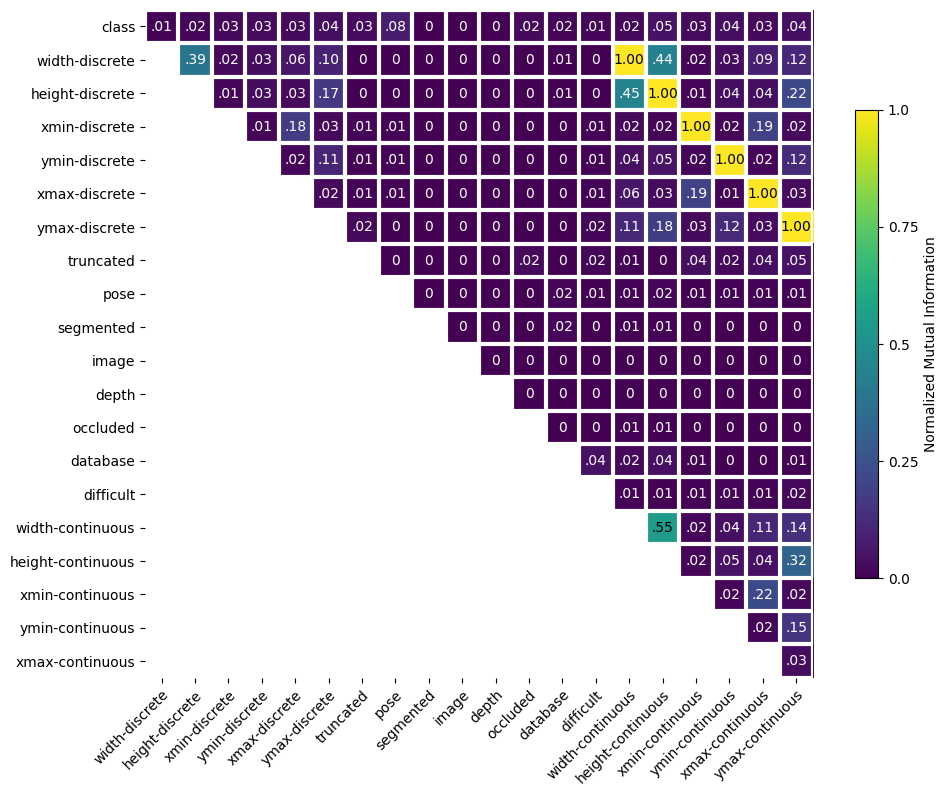

In [ ]:
_ = bal.plot()

The heatmap shows that the greatest correlations are in the bounding box locations (_xmin_ with _xmax_ and _ymin_ with _ymax_) and the image dimensions (_height_ and _width_).
Also the _ymax_ of the bounding box location is correlated with the _height_ of the image.
It is not surprising that _height_ and _width_ have correlation since many of the images are similarly sized.
The correlations between _xmin_ and _xmax_ and between _ymin_ and _ymax_ suggests that there is repetition in bounding box width and height across the objects.
However, the fact that _pose_ has a value near 0.10 with _class_ means that a few of the classes have specific poses across a fair percentage of the images for that class.
An example of this would be most _pottedplant_ images having the same _pose_ value.

In addition to analyzing class and other factors, the balance function also analyzes metadata factors with individual classes to identify relationships between only one class and secondary factors.
Again, the plot function of the balance output class can plot a heatmap of the classwise results for visualizing.
The `plot_classwise` parameter needs to be set to True to use the classwise results.


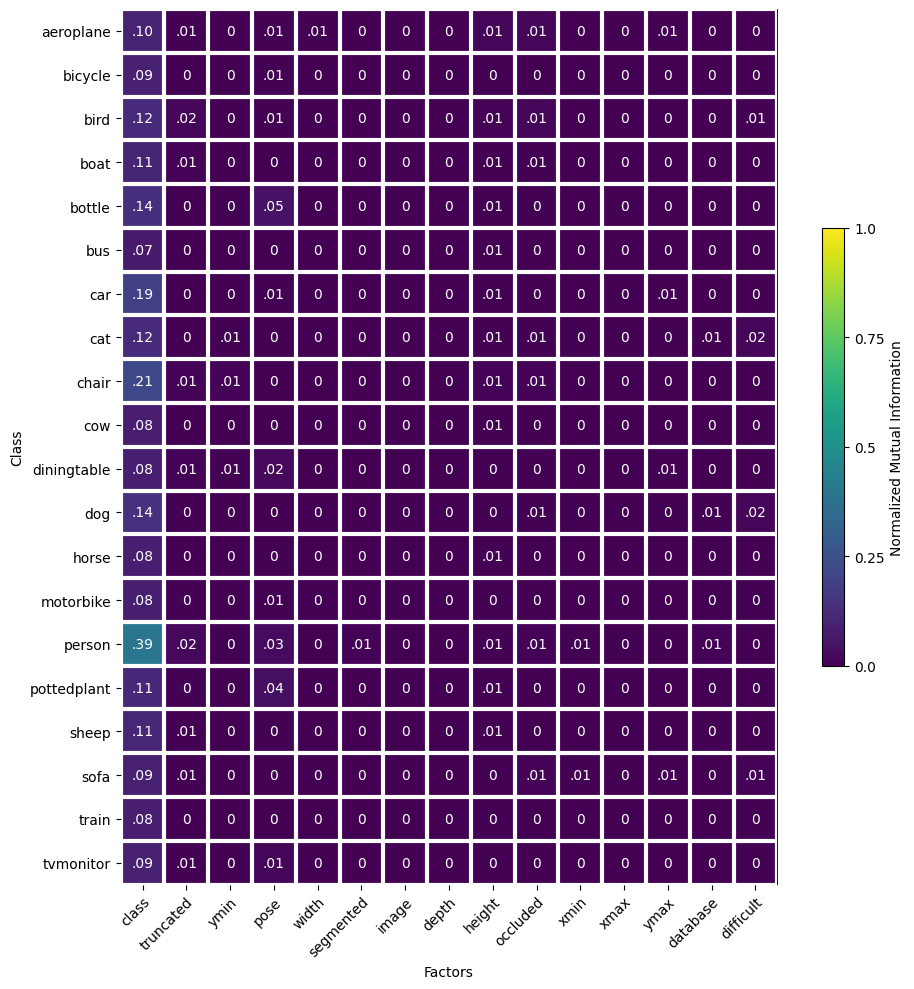

In [23]:
_ = bal.plot(plot_classwise=True)

The classwise heatmap shows that factors other than _class_ do not have any significant correlation with a specific class.
Classwise balance shows correlation of individual classes with all class labels, indicating relative class imbalance.
In this case the _person_ class is over-represented relative to most other classes.
This means that a model might learn a bias towards the _person_ class label due to its frequency in the training set, which becomes a problem if the test/operational dataset doesn't have the same imbalance.


## Step 4: Checking Dataset Diversity


The `diversity` function measures the evenness or uniformity of the sampling of metadata factors over a dataset.
Values near 1 indicate uniform sampling, while values near 0 indicate imbalanced sampling, e.g. all values taking a single value.

The results can be retrieved using the diversity_index key from the output.


In [12]:
div = diversity(metadata)

Again, it's often easiest to see the differences between the different factors when visualizing them.
The diversity output function contains a plot function to plot the results of the diversity function.
It uses a box plot to plot the factor-class analysis.


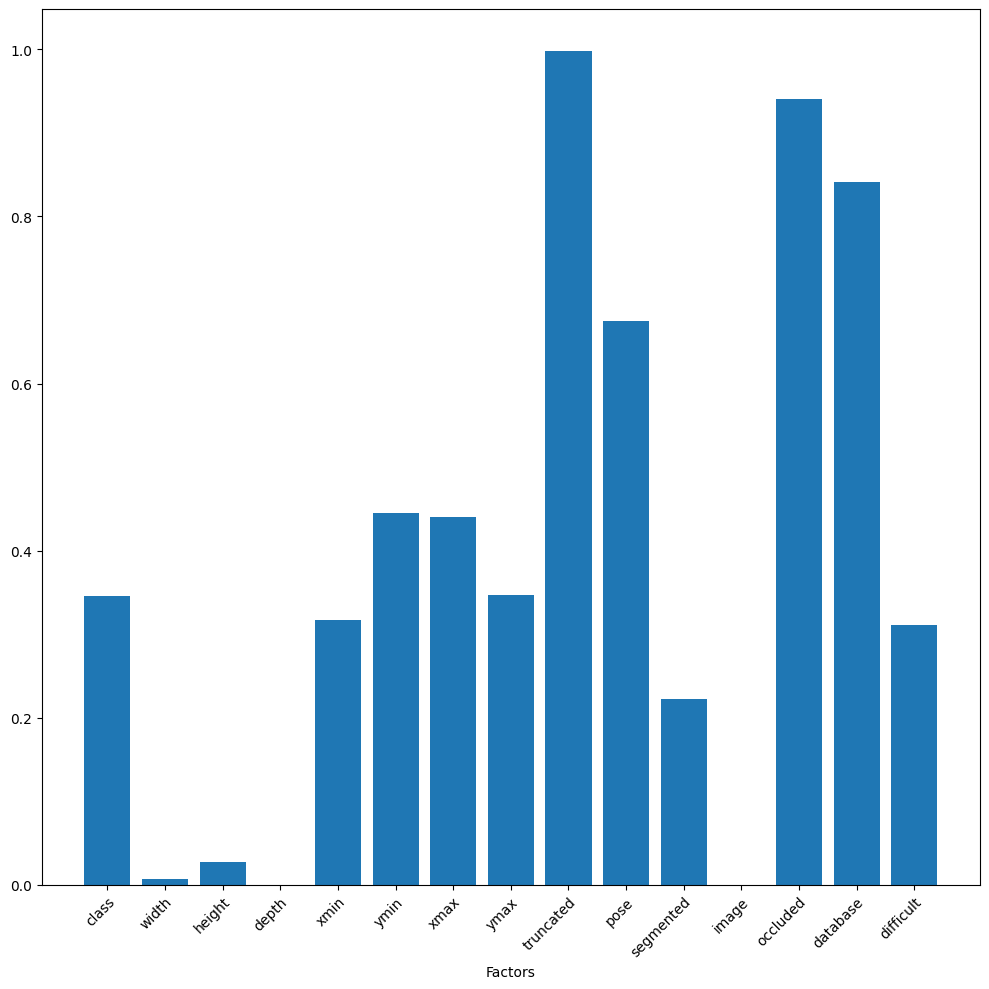

In [13]:
_ = div.plot()

When analyzing a diversity plot, there are two key values to keep in mind, 1 and 0. A 1 represents uniform sampling and an unbiased factor, while a 0 represents a constant value for all samples.
Factors with a diversity value of 0 do not provide insight as to whether you have adequately sampled the data space, for more information see the [Diversity](../concepts/Diversity.md) concept page. Diversity values near 1 indicate unbiased factors while values below 0.5 indicate basis in the factor.

In the results above, the metadata factors _image_ and _channels_ contain only a single value and do not contribute to our bias analysis.
The factors _truncated_ and _occluded_ have values near 1, meaning that there is relatively little or no bias in these factors.
The categories of most interest are those that are between 0.5 and 0.2 because this region represents skewed value distributions for the factor.
The following factors fall into this category:

- _class_
- _width_
- _height_
- _segmented_
- _difficult_

These factors contain bias that should be addressed either by adding or removing data to even out the sampling.
For instance, the _class_ factor highlights that there is unevenness in the number of data points per class.

In addition to analyzing class, the diversity function also analyzes metadata factors with individual classes to assess uniformity of metadata factors within a class.
As above, the plot function of the diversity output class can plot a heatmap of the classwise results for visualizing.
The `plot_classwise` parameter needs to be set to True to use the classwise results.


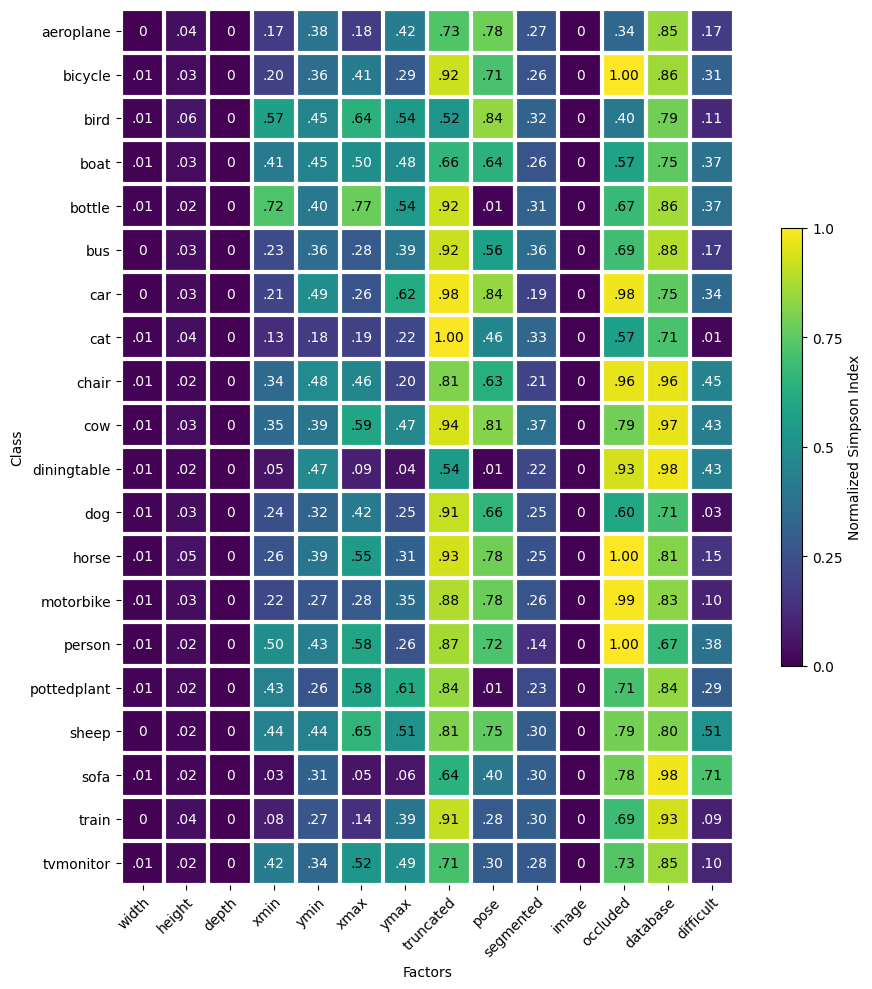

In [14]:
_ = div.plot(plot_classwise=True)

These results expand the above results on a per class basis.
Things to look for here are large variances for a given factor across the different classes.
For example, _pose_ has values ranging from 0.01 to 0.84, which means that a few classes have almost uniform selection of the different _pose_ values while other classes essentially only have one _pose_ value.
Should classes have different selections of _pose_ value? Yes, one would not expect the _diningtable_ class to have a _pose_ direction, while the _person_ class should have multiple _pose_ directions.
What needs to be further investigated are things like whether the _sofa_ class should have a _pose_ direction, because a diversity value of 0.4 means that a few of the images do while others do not.
Also, the _cat_ class has a low score signifying that most of the images fall into one or two categories rather than being spread even across the categories.
This highlights an error in the data collection process &mdash; the value was not specified for most _cat_ images and therefore defaulted to "Unspecified".
An alternative error would be a dataset in which the _cat_ images have most cats facing a specific direction, which would require additional data to overcome the bias,
but that is not the case for this dataset. It has plenty of cats facing each direction, but only a few of them contain a _pose_ value.


## Step 5: Checking Dataset Parity


The `parity` function measures the relationship between metadata factors and classes using a chi-squared test.
A high score with a low p-value suggests that a metadata factor is strongly correlated with a class label.

The results can be retrieved using the score and p-value keys from the output.


In [15]:
par = parity(metadata)

/home/aweng/dataeval/src/dataeval/metrics/bias/parity.py:315: UserWarning: The following factors did not meet the recommended 5 occurrences for each value-label combination. 
            Recommend rerunning parity after adjusting the following factor-value-label combinations: 
width - value 1 - label bottle: 1 occurrences
	value 12 - label bottle: 1 occurrences
	value 13 - label bottle: 1 occurrences
	value 14 - label bottle: 1 occurrences
	value 17 - label person: 2 occurrences
	value 20 - label person: 1 occurrences
	value 30 - label sofa: 2 occurrences
	value 31 - label car: 1 occurrences
		label dog: 1 occurrences
		label person: 1 occurrences
		label tvmonitor: 2 occurrences
	value 33 - label cat: 1 occurrences
		label cow: 1 occurrences
		label dog: 1 occurrences
	value 34 - label bicycle: 1 occurrences
		label person: 1 occurrences
	value 35 - label cat: 2 occurrences
		label dog: 1 occurrences
		label person: 3 occurrences
		label sofa: 1 occurrences
	value 36 - label bicycle: 

The warning above states that the metric works best when there are more than 5 samples in each value-label combination.
However, because of the large number of total samples, the difference between 1 and 5 samples does not significantly affect the results.

When evaluating the results of parity for a large number of factors, it may be easier to understand the results by presenting the score and p-value for a given factor together.
The code below restructures the result to this structure.


In [16]:
for key, score, value in zip(par.metadata_names or [], par.score, par.p_value):
    print(f"{key:>9} - {round(score, 2):>7} : {round(value, 2):>3}")

    width - 2767.36 : 0.0
   height -  5404.0 : 0.0
    depth -     0.0 : 1.0
     xmin - 3704.49 : 0.0
     ymin - 4126.08 : 0.0
     xmax - 3881.55 : 0.0
     ymax - 5019.04 : 0.0
truncated - 1413.02 : 0.0
     pose -  4732.1 : 0.0
segmented -  158.47 : 0.0
    image -     0.0 : 1.0
 occluded - 1166.67 : 0.0
 database -  990.93 : 0.0
difficult -  529.53 : 0.0


According to the results, all metadata are correlated with _class_ labels, except for _image_ and _channels_.
However, parity is based on the idea of an expected frequency and how the observed differs from what is expected.
The expected frequencies are determined by sums of the values for each metadata category.

This function works best when the expected frequencies for a given factor for each individual class are known a priori.
So for the case above, the expected frequency for the _pose_ metadata category shouldn't be the same for all classes.
_Diningtable_, _pottedplant_, and _bottle_ should only have a single value for _pose_ which automatically throws off the metric because not all of the classes have an identical expected frequency for _pose_.


## Conclusion


Having analyzed the dataset for bias with multiple metrics, the concluding answer is this dataset has bias.
Training a model on this dataset has the potential to learn shortcuts and underperform on operational data if the biases are not representative of biases in the operational dataset.

The metadata categories identified by the `balance`, `diversity` and `parity` functions contain issues such as imbalanced classes and imbalanced parameters per class.
DataEval isn't able to tell you exactly why they are imbalanced, but it highlights the categories that you need to check.

As you can see, the DataEval methods are here to help you gain a deep understanding of your dataset and all of its strengths and limitations.
It is designed to help you create representative and reliable datasets.

Good luck with your data!

---


## What's Next

In addition to identifying bias and correlations in a dataset, DataEval offers additional tutorials to help you learn about dataset analysis:

- To clean a dataset use the [Data Cleaning Guide](EDA_Part1.ipynb).
- To identify coverage gaps and outliers use the [Assessing the Data Space Guide](EDA_Part2.ipynb).
- To monitor data for shifts during operation use the [Data Monitoring Guide](Data_Monitoring.ipynb).

To learn more about the balance, diversity and parity functions, see the [Balance](../concepts/Balance.md), [Diversity](../concepts/Diversity.md) and [Parity](../concepts/Parity.md) concept pages.

## On your own

Once you are familiar with DataEval and dataset analysis, you will want to run this analysis on your own dataset.
When you do, make sure that you analyze all of your data and not just the training set.
